In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# CUDA Results Visualisation

## Data Preprocessing

1. Load the data

In [178]:
# Load the data
df = pd.read_csv('CUDA.csv')
df.shape

(2400, 11)

In [179]:
len(df["m"].unique())

30

2. Keep only valid results

In [180]:
df = df[(df['CRS'] == 1) & (df['ELLPACK'] == 1)]
df.shape

(2310, 11)

In [181]:
len(df["m"].unique())

30

3. Add the name of each sparse matrix

In [182]:
def getMatrixName(m):
    if m == 2597:
        return 'cavity10'
    if m == 161070:
        return 'PR02R'
    if m == 1062400:
        return 'nlpkkt80'
    if m == 2164760:
        return 'Cube_Coup_dt0'
    if m == 1090920:
        return 'roadNet-PA'
    if m == 377002:
        return 'ML_Laplace'
    if m == 10974:
        return 'bcsstk17'
    if m == 416:
        return 'mhda416'
    if m == 503625:
        return 'af_1_k101'
    if m == 82654:
        return 'thermal1'
    if m == 1228045:
        return 'thermal2'
    if m == 102158:
        return 'thermomech_TK'
    if m == 9:
        return 'cage4'
    if m == 62451:
        return 'cant'
    if m == 116835:
        return 'dc1'
    if m == 3242:
        return 'raefsky2'
    if m == 3198:
        return 'rdist2'
    if m == 765:
        return 'mcfe'
    if m == 1000:
        return 'olm1000'
    if m == 109460:
        return 'lung2'
    if m == 1000005:
        return 'webbase-1M'
    if m == 4800:
        return 'mhd4800a'
    if m == 2021:
        return 'west2021'
    if m == 1813:
        return 'adder_dcop_32'
    if m == 206500:
        return 'mac_econ_fwd500'
    if m == 17880:
        return 'FEM_3D_thermal1'
    if m == 262111:
        return 'amazon0302'
    if m == 121192:
        return 'cop20k_A'
    if m == 16146:
        return 'olafu'
    if m == 24:
        return 'can_24'
    if m == 23560:
        return 'af23560' 
    if m == 416:
        return 'mhda416'
    else:
        print("Problem with m = ", m)
    
df['Matrix'] = df['m'].apply(getMatrixName)
df['Matrix'].value_counts()

Matrix
cop20k_A           80
mhd4800a           80
roadNet-PA         80
olm1000            80
lung2              80
webbase-1M         80
west2021           80
thermomech_TK      80
thermal2           80
thermal1           80
rdist2             80
raefsky2           80
nlpkkt80           80
adder_dcop_32      80
ML_Laplace         80
mac_econ_fwd500    80
FEM_3D_thermal1    80
dc1                80
cage4              80
cavity10           80
cant               80
amazon0302         80
af23560            80
af_1_k101          80
mhda416            80
bcsstk17           70
mcfe               60
olafu              60
PR02R              60
Cube_Coup_dt0      60
Name: count, dtype: int64

In [183]:
df["Matrix"].unique()

array(['cop20k_A', 'adder_dcop_32', 'bcsstk17', 'af_1_k101', 'af23560',
       'amazon0302', 'cant', 'cavity10', 'cage4', 'dc1', 'Cube_Coup_dt0',
       'FEM_3D_thermal1', 'mac_econ_fwd500', 'mcfe', 'mhd4800a',
       'ML_Laplace', 'nlpkkt80', 'olafu', 'PR02R', 'raefsky2', 'rdist2',
       'thermal1', 'thermal2', 'thermomech_TK', 'west2021', 'webbase-1M',
       'lung2', 'olm1000', 'roadNet-PA', 'mhda416'], dtype=object)

4. Compute the average performance of serial algorithms for each matrix

In [184]:
serial_df = df[['Matrix', 'm', 'k', 'NZ', 'Serial CRS performance', 'Serial ELLPACK performance']].groupby(['Matrix', 'k', 'NZ', 'm']).mean().reset_index().sort_values(by='NZ', ascending=False)

## Effect of X BlockSize, k and NZ on performance

### CRS Format

In [185]:
df_best_CRS_xB = df[['Matrix', 'k', 'NZ', 'xBlockSize', 'yBlockSize', 'CRS performance']]\
    .groupby(['Matrix', 'k', 'xBlockSize'])\
    .apply(lambda x: x.loc[x['CRS performance'].idxmax()])\
    .reset_index(drop=True)

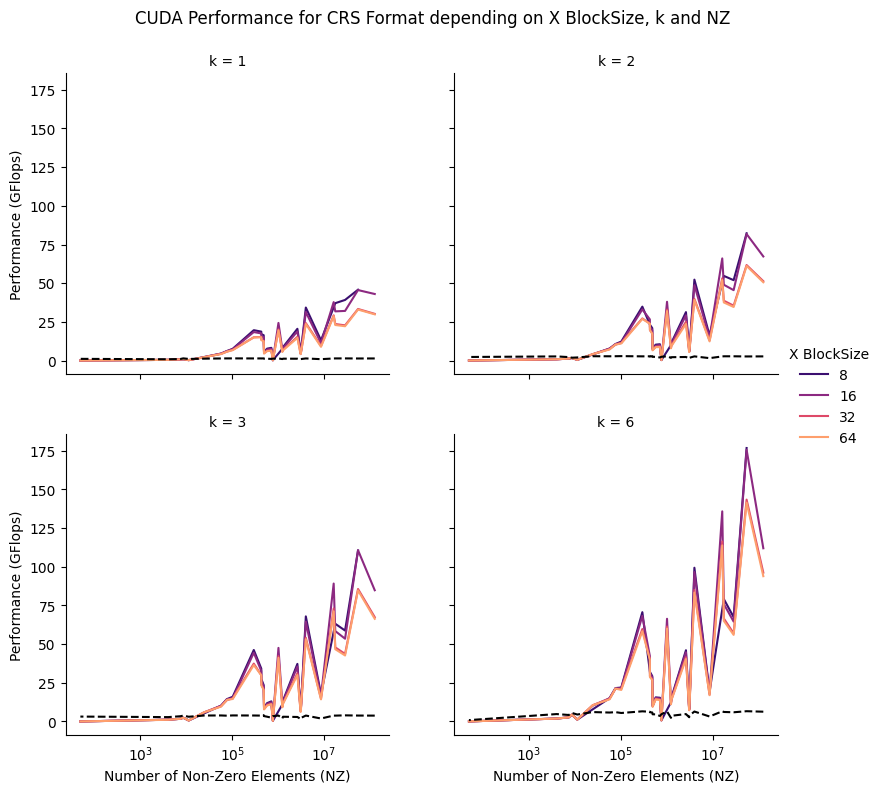

In [186]:
# Order NZ values for better visualization
df_best_CRS_xB = df_best_CRS_xB.sort_values(by='NZ')

g = sns.FacetGrid(df_best_CRS_xB, col="k", hue="xBlockSize", col_wrap=2, height=4, palette="magma", sharex=True, sharey=True)

# Ajouter des lignes pour chaque grille avec les performances en fonction des threads
g = g.map(sns.lineplot, "NZ", "CRS performance")

# Add the Serial CRS performance in each graph
for ax in g.axes:
    serial_df_k = serial_df[serial_df['k'] == int(ax.title.get_text().split('=')[1])]
    ax.plot(serial_df_k['NZ'], serial_df_k['Serial CRS performance'], label='Serial', color='black', linestyle='--')


# Ajouter un titre global avec plt.subplots_adjust()
plt.subplots_adjust(top=0.9)
plt.xscale('log')
g.fig.suptitle('CUDA Performance for CRS Format depending on X BlockSize, k and NZ')

# Ajouter un titre pour chaque sous-graphique indiquant la valeur de 'k'
g.set_titles("k = {col_name}")
g.set_xlabels("Number of Non-Zero Elements (NZ)")
g.set_ylabels("Performance (GFlops)")

# Ajouter des légendes
g.add_legend(title="X BlockSize")

# Ajuster l'espace entre les graphiques pour clarté
g.fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Sauvegarder le graphique
plt.savefig('./images/CUDA_xBlockSize_CRS.png')

plt.show()

### ELLPACK Format

In [187]:
df_best_ELLPACK_xB = df[['Matrix', 'k', 'NZ', 'xBlockSize', 'yBlockSize', 'ELLPACK performance']]\
    .groupby(['Matrix', 'k', 'xBlockSize'])\
    .apply(lambda x: x.loc[x['ELLPACK performance'].idxmax()])\
    .reset_index(drop=True)

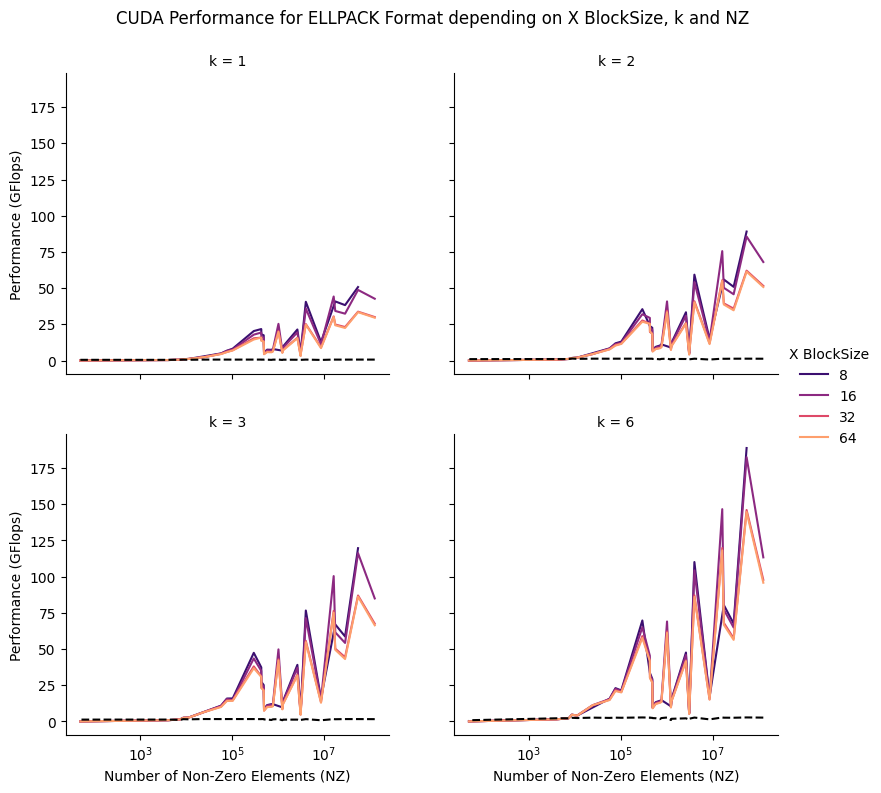

In [188]:
# Order NZ values for better visualization
df_best_ELLPACK_xB = df_best_ELLPACK_xB.sort_values(by='NZ')

g = sns.FacetGrid(df_best_ELLPACK_xB, col="k", hue="xBlockSize", col_wrap=2, height=4, palette="magma", sharex=True, sharey=True)

# Ajouter des lignes pour chaque grille avec les performances en fonction des threads
g = g.map(sns.lineplot, "NZ", "ELLPACK performance")

# Add the Serial ELLPACK performance in each graph
for ax in g.axes:
    serial_df_k = serial_df[serial_df['k'] == int(ax.title.get_text().split('=')[1])]
    ax.plot(serial_df_k['NZ'], serial_df_k['Serial ELLPACK performance'], label='Serial', color='black', linestyle='--')


# Ajouter un titre global avec plt.subplots_adjust()
plt.subplots_adjust(top=0.9)
plt.xscale('log')
g.fig.suptitle('CUDA Performance for ELLPACK Format depending on X BlockSize, k and NZ')

# Ajouter un titre pour chaque sous-graphique indiquant la valeur de 'k'
g.set_titles("k = {col_name}")
g.set_xlabels("Number of Non-Zero Elements (NZ)")
g.set_ylabels("Performance (GFlops)")

# Ajouter des légendes
g.add_legend(title="X BlockSize")

# Ajuster l'espace entre les graphiques pour clarté
g.fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Save the figure
plt.savefig("./images/CUDA_xBlockSize_ELLPACK.png")

plt.show()


## Effect of Y BlockSize, k and NZ on performance

### CRS Format

In [189]:
df_best_CRS_yB = df[['Matrix', 'k', 'NZ', 'xBlockSize', 'yBlockSize', 'CRS performance']]\
    .groupby(['Matrix', 'k', 'yBlockSize'])\
    .apply(lambda x: x.loc[x['CRS performance'].idxmax()])\
    .reset_index(drop=True)

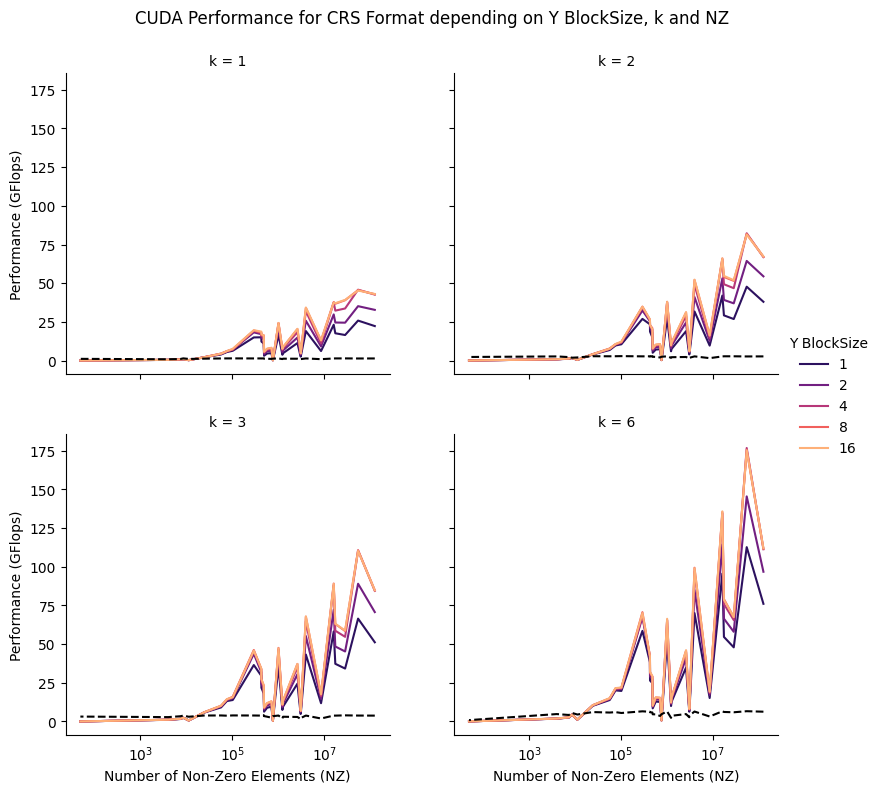

In [190]:
# Order NZ values for better visualization
df_best_CRS_yB = df_best_CRS_yB.sort_values(by='NZ')

g = sns.FacetGrid(df_best_CRS_yB, col="k", hue="yBlockSize", col_wrap=2, height=4, palette="magma", sharex=True, sharey=True)

# Ajouter des lignes pour chaque grille avec les performances en fonction des threads
g = g.map(sns.lineplot, "NZ", "CRS performance")

# Add the Serial CRS performance in each graph
for ax in g.axes:
    serial_df_k = serial_df[serial_df['k'] == int(ax.title.get_text().split('=')[1])]
    ax.plot(serial_df_k['NZ'], serial_df_k['Serial CRS performance'], label='Serial', color='black', linestyle='--')


# Ajouter un titre global avec plt.subplots_adjust()
plt.subplots_adjust(top=0.9)
plt.xscale('log')
g.fig.suptitle('CUDA Performance for CRS Format depending on Y BlockSize, k and NZ')

# Ajouter un titre pour chaque sous-graphique indiquant la valeur de 'k'
g.set_titles("k = {col_name}")
g.set_xlabels("Number of Non-Zero Elements (NZ)")
g.set_ylabels("Performance (GFlops)")

# Ajouter des légendes
g.add_legend(title="Y BlockSize")

# Ajuster l'espace entre les graphiques pour clarté
g.fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Save the figure
plt.savefig("./images/CUDA_yBlockSize_CRS.png")

plt.show()


### ELLPACK Format

In [191]:
df_best_ELLPACK_yB = df[['Matrix', 'k', 'NZ', 'xBlockSize', 'yBlockSize', 'ELLPACK performance']]\
    .groupby(['Matrix', 'k', 'yBlockSize'])\
    .apply(lambda x: x.loc[x['ELLPACK performance'].idxmax()])\
    .reset_index(drop=True)

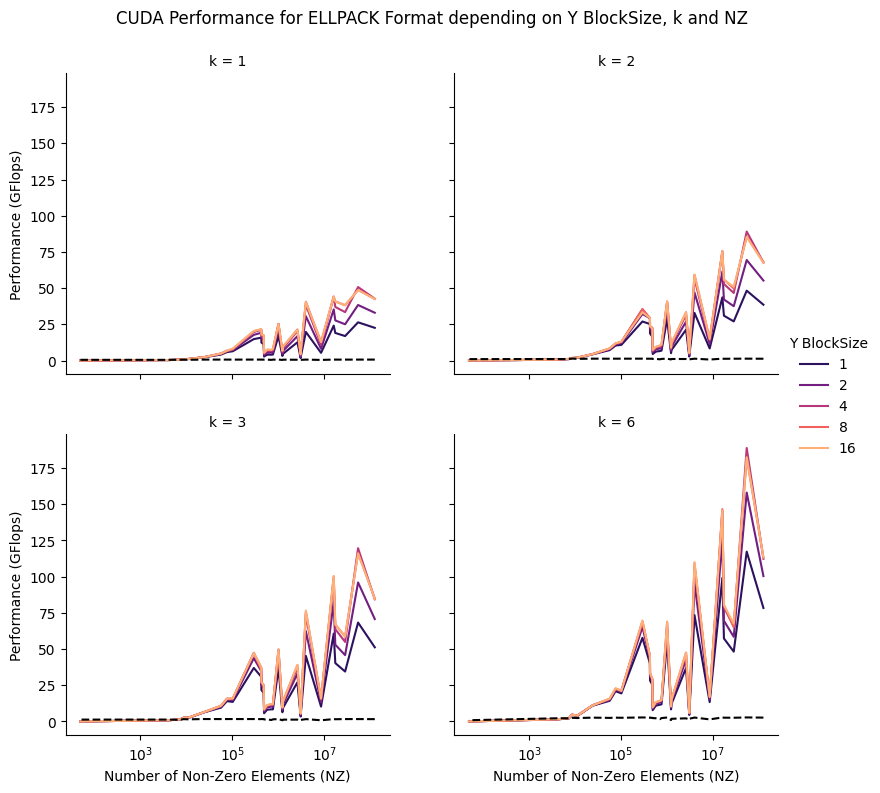

In [192]:
# Order NZ values for better visualization
df_best_ELLPACK_yB = df_best_ELLPACK_yB.sort_values(by='NZ')

g = sns.FacetGrid(df_best_ELLPACK_yB, col="k", hue="yBlockSize", col_wrap=2, height=4, palette="magma", sharex=True, sharey=True)

# Ajouter des lignes pour chaque grille avec les performances en fonction des threads
g = g.map(sns.lineplot, "NZ", "ELLPACK performance")

# Add the Serial ELLPACK performance in each graph
for ax in g.axes:
    serial_df_k = serial_df[serial_df['k'] == int(ax.title.get_text().split('=')[1])]
    ax.plot(serial_df_k['NZ'], serial_df_k['Serial ELLPACK performance'], label='Serial', color='black', linestyle='--')


# Ajouter un titre global avec plt.subplots_adjust()
plt.subplots_adjust(top=0.9)
plt.xscale('log')
g.fig.suptitle('CUDA Performance for ELLPACK Format depending on Y BlockSize, k and NZ')

# Ajouter un titre pour chaque sous-graphique indiquant la valeur de 'k'
g.set_titles("k = {col_name}")
g.set_xlabels("Number of Non-Zero Elements (NZ)")
g.set_ylabels("Performance (GFlops)")

# Ajouter des légendes
g.add_legend(title="Y BlockSize")

# Ajuster l'espace entre les graphiques pour clarté
g.fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Save the figure
plt.savefig("./images/CUDA_yBlockSize_ELLPACK.png")

plt.show()


## Serial vs Parallel Algorithms Performance Comparison

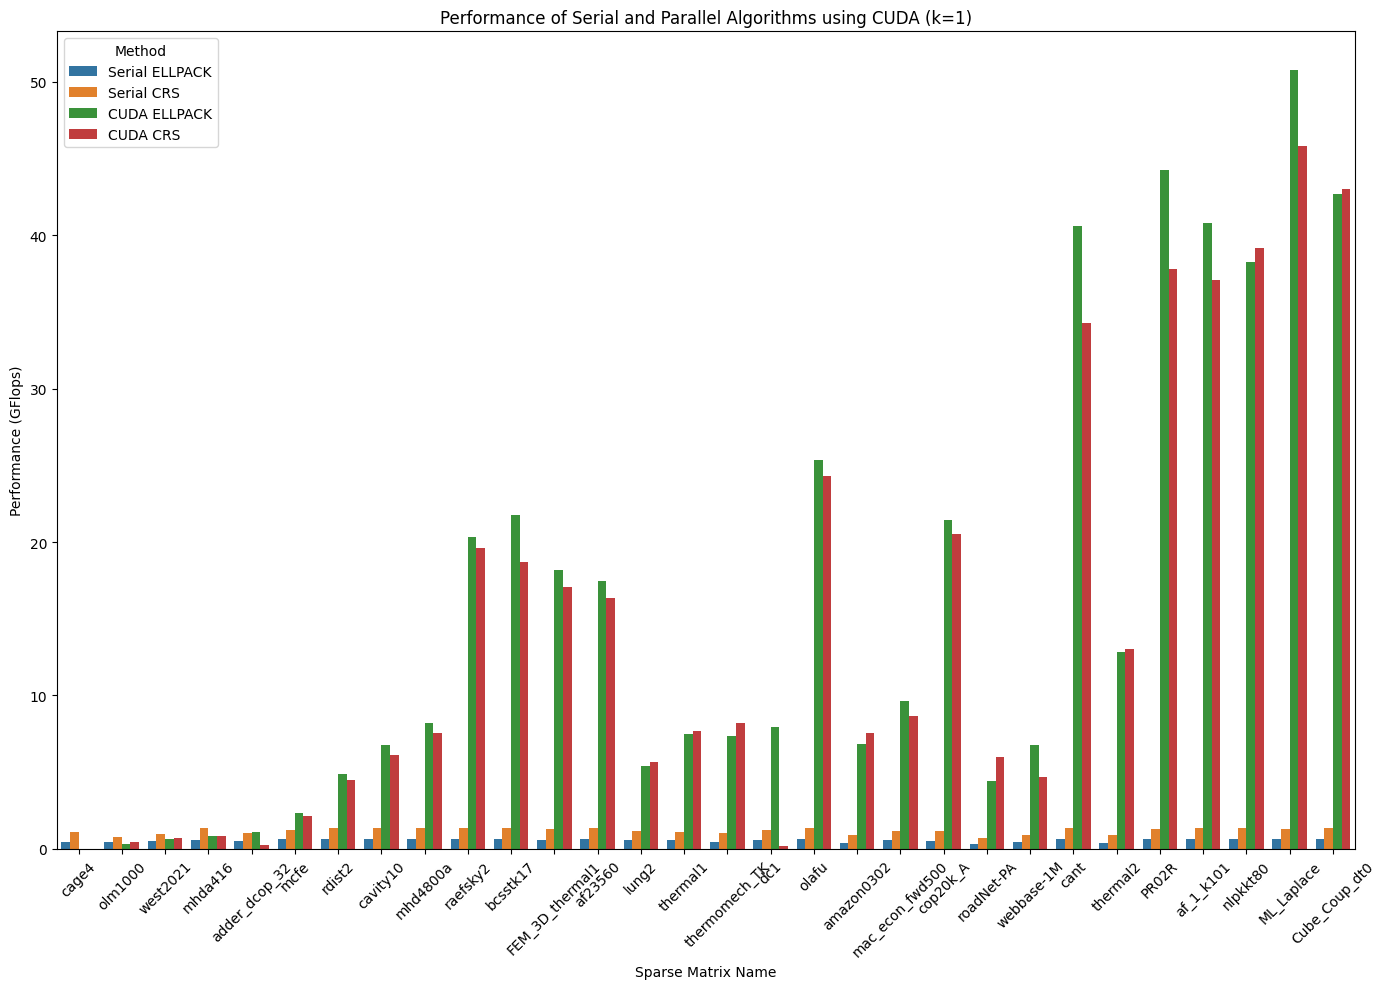

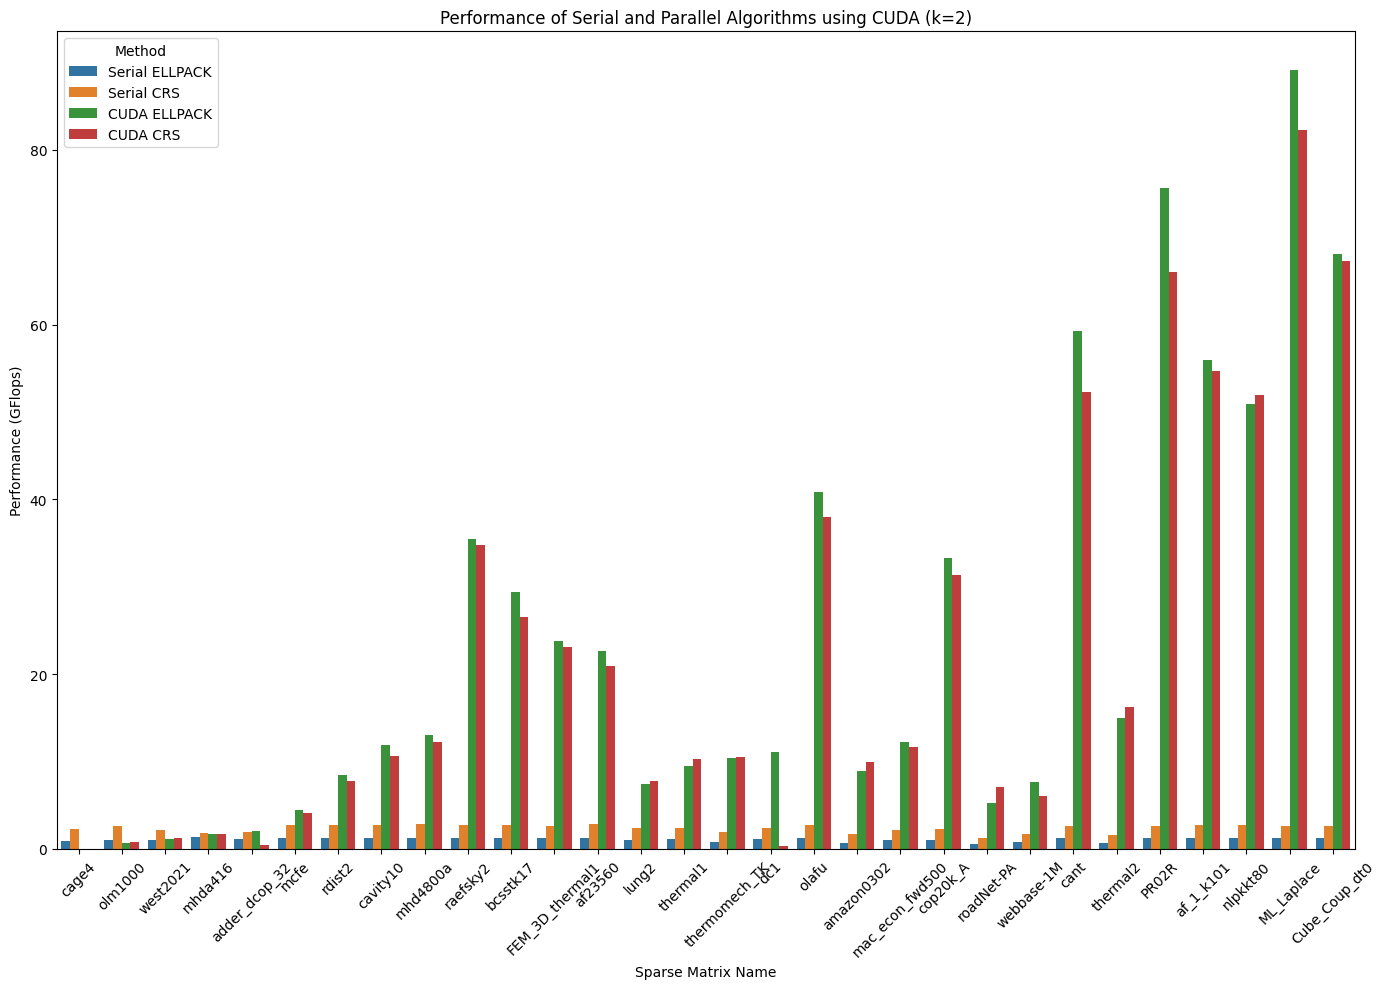

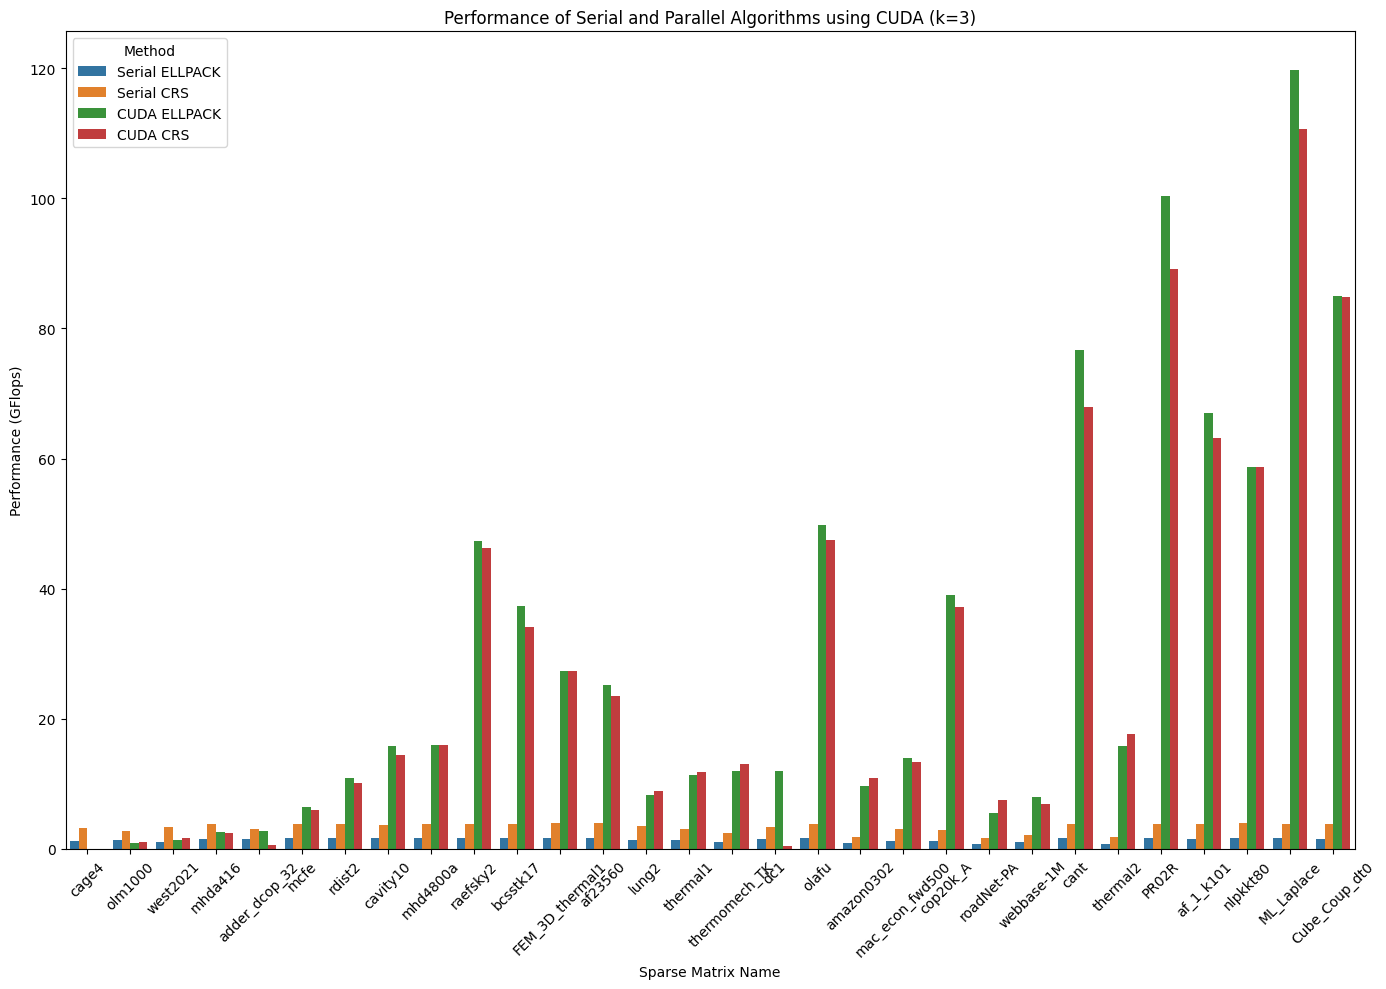

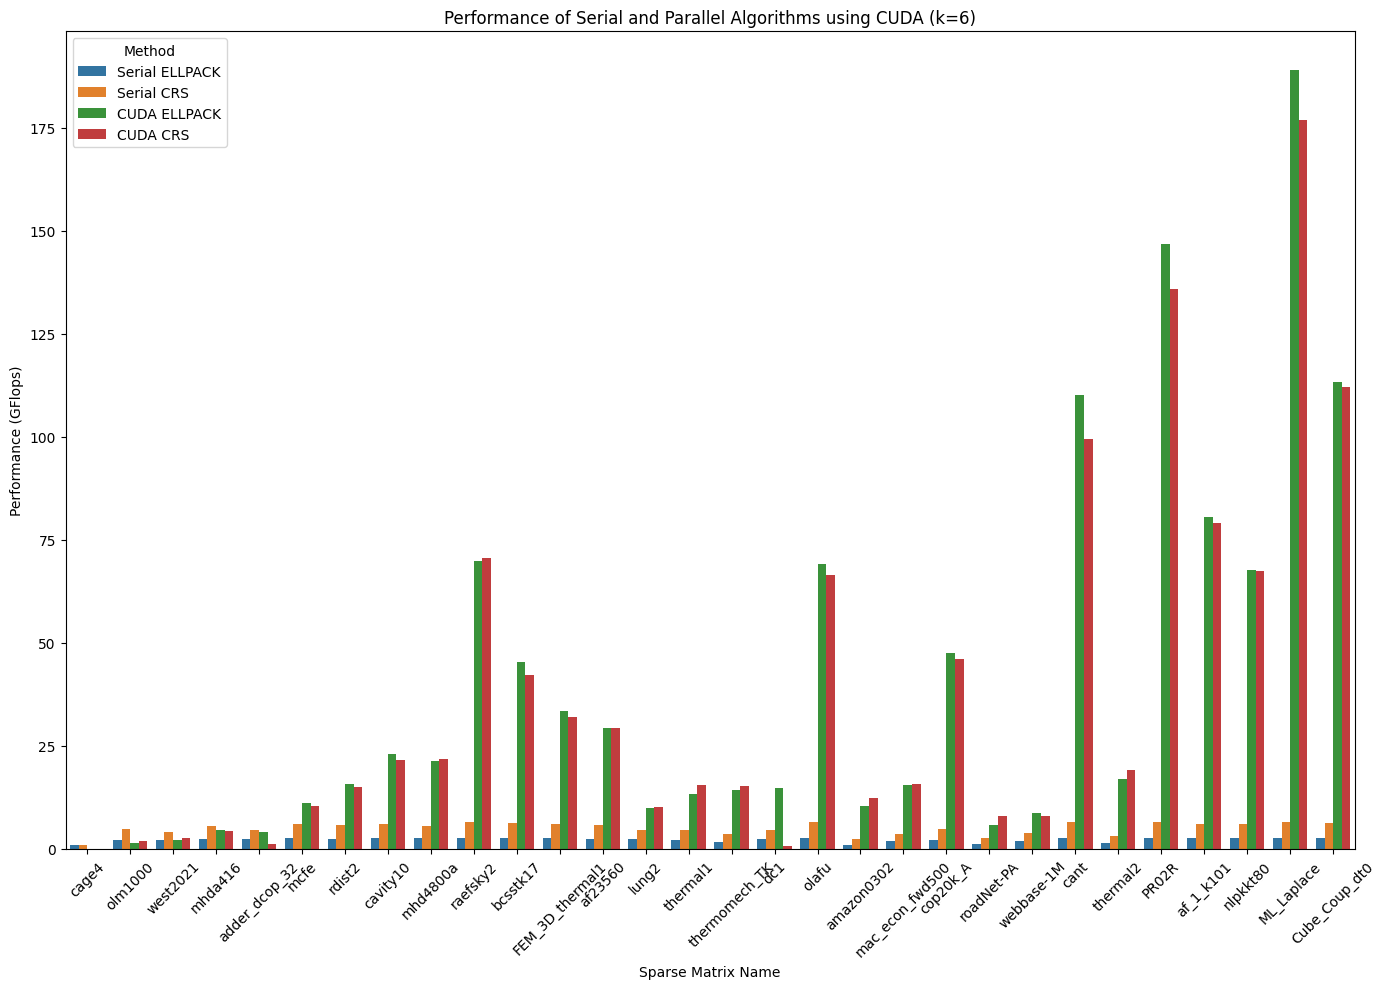

In [193]:
for index, k_value in enumerate(df["k"].unique()):
    df_sorted = df[df["k"] == k_value].sort_values("NZ")

    best_crs_perf = df_sorted.loc[
        df_sorted.groupby("Matrix")["CRS performance"].idxmax(),
        ["Matrix", "NZ", "CRS performance"]
    ]
    best_ellpack_perf = df_sorted.loc[
        df_sorted.groupby("Matrix")["ELLPACK performance"].idxmax(),
        ["Matrix", "NZ", "ELLPACK performance"]
    ]

    # Fusion avec 'serial_df' – Assurez-vous que 'serial_df' est correctement préparé pour cette opération
    df_best_perf = pd.merge(
        best_crs_perf,
        best_ellpack_perf,
        on=["Matrix", "NZ"],
        how="outer",
        suffixes=("_CRS", "_ELLPACK")
    )
    df_best_perf = pd.merge(
        df_best_perf,
        serial_df[serial_df["k"] == k_value],
        on=["Matrix", "NZ"],
        how="outer"
    )

    # Transformation des données
    df_melted = df_best_perf.melt(
        id_vars=["Matrix", "NZ"], 
        value_vars=[
            "CRS performance", 
            "ELLPACK performance", 
            "Serial CRS performance", 
            "Serial ELLPACK performance"
        ],
        var_name="Method", 
        value_name="Performance"
    )

    # Personnalisation des noms de méthode
    method_mapping = {
        "CRS performance": "CUDA CRS",
        "ELLPACK performance": "CUDA ELLPACK",
        "Serial CRS performance": "Serial CRS",
        "Serial ELLPACK performance": "Serial ELLPACK"
    }
    df_melted["Method"] = df_melted["Method"].map(method_mapping)

    # Order by NZ
    df_melted = df_melted.sort_values("NZ")

    plt.figure(figsize=(14, 10))
    sns.barplot(
        data=df_melted,
        x="Matrix",
        y="Performance",
        hue="Method",
        dodge=True,
    )

    plt.title(f"Performance of Serial and Parallel Algorithms using CUDA (k={k_value})")
    plt.xlabel("Sparse Matrix Name")
    plt.ylabel("Performance (GFlops)")
    plt.xticks(rotation=45)
    plt.legend(title="Method")
    plt.tight_layout()

    # Save the figure
    plt.savefig(f"./images/CUDA_Performance_k{k_value}.png")

    plt.show()


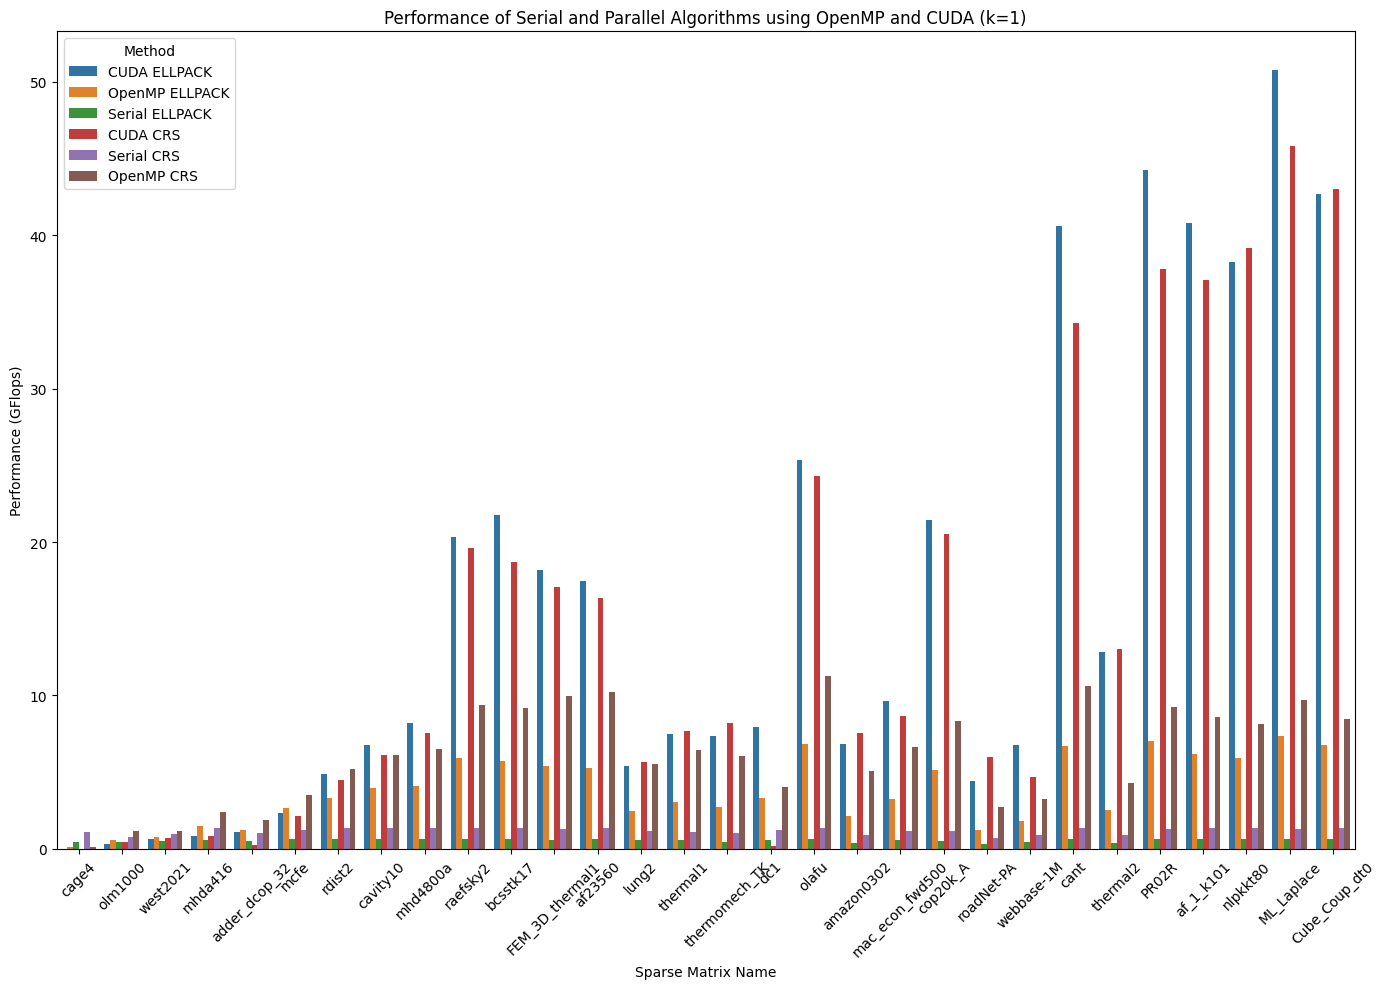

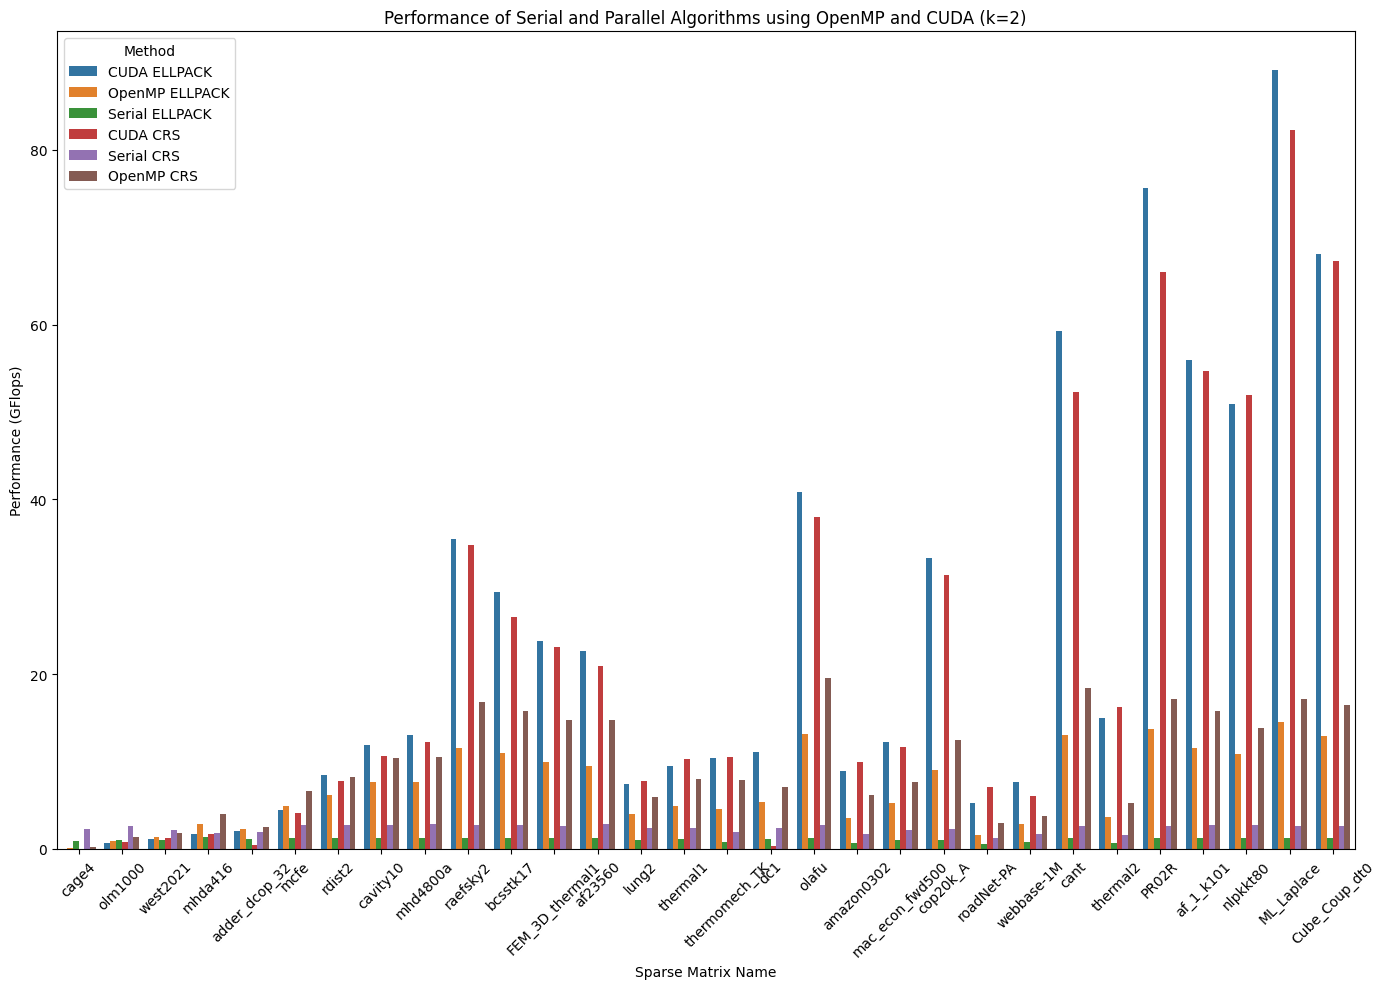

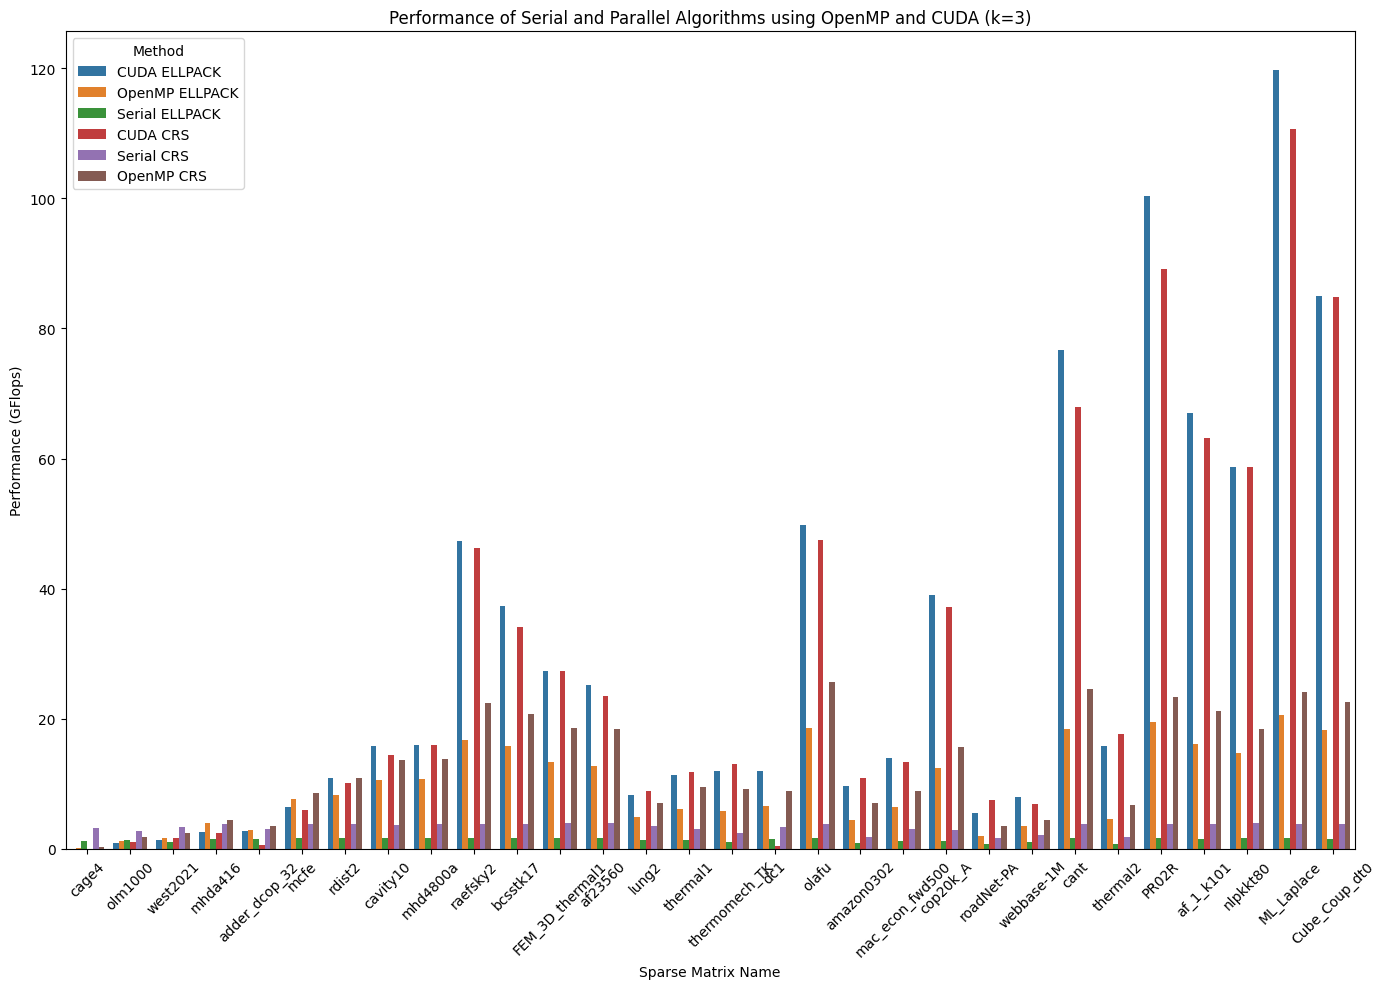

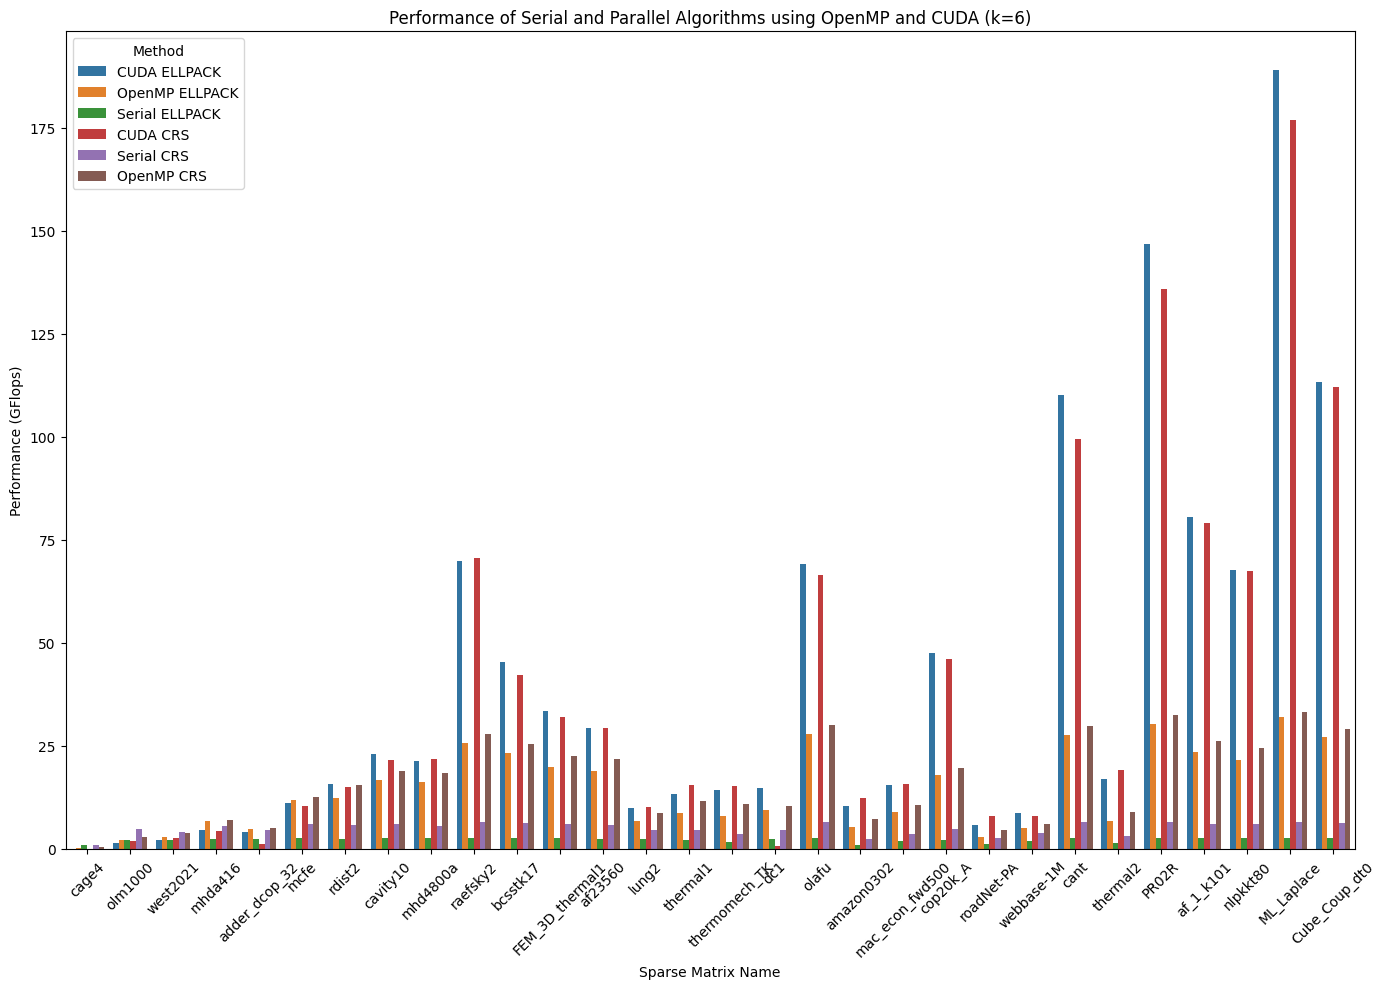

In [194]:
df_openmp = pd.read_csv("openMP.csv")
df_openmp = df_openmp[(df_openmp["ELLPACK"] == 1) & (df_openmp["CRS"] == 1)]
df_openmp["Matrix"] = df_openmp["m"].apply(getMatrixName)

for index, k_value in enumerate(df_openmp["k"].unique()):
    df_sorted_openMP = df_openmp[df_openmp["k"] == k_value].sort_values("NZ")
    df_sorted_CUDA = df[df["k"] == k_value].sort_values("NZ")

    best_crs_perf_openMP = df_sorted_openMP.loc[
        df_sorted_openMP.groupby("Matrix")["CRS performance"].idxmax(),
        ["Matrix", "NZ", "CRS performance"],
    ]
    best_ellpack_perf_openMP = df_sorted_openMP.loc[
        df_sorted_openMP.groupby("Matrix")["ELLPACK performance"].idxmax(),
        ["Matrix", "NZ", "ELLPACK performance"],
    ]
    best_crs_perf_CUDA = df_sorted_CUDA.loc[
        df_sorted_CUDA.groupby("Matrix")["CRS performance"].idxmax(),
        ["Matrix", "NZ", "CRS performance"],
    ]
    best_ellpack_perf_CUDA = df_sorted_CUDA.loc[
        df_sorted_CUDA.groupby("Matrix")["ELLPACK performance"].idxmax(),
        ["Matrix", "NZ", "ELLPACK performance"],
    ]

    df_best_perf = pd.merge(
        best_crs_perf_openMP,
        best_ellpack_perf_openMP,
        on=["Matrix", "NZ"],
        suffixes=("_OpenMP_CRS", "_OpenMP_ELLPACK"),
        how="outer",
    )

    df_best_perf = pd.merge(
        df_best_perf,
        best_crs_perf_CUDA,
        on=["Matrix", "NZ"],
        suffixes=("_OpenMP_CRS", "_CUDA_CRS"),
        how="outer",
    )

    df_best_perf = pd.merge(
        df_best_perf,
        best_ellpack_perf_CUDA,
        on=["Matrix", "NZ"],
        suffixes=("_OpenMP_ELLPACK", "_CUDA_ELLPACK"),
        how="outer",
    )

    df_best_perf = pd.merge(
        df_best_perf,
        serial_df[serial_df["k"] == k_value],
    )

    # Transformation des données
    df_melted = df_best_perf.melt(
        id_vars=["Matrix", "NZ"],
        value_vars=[
            "CRS performance_OpenMP_CRS",
            "ELLPACK performance_OpenMP_ELLPACK",
            "CRS performance_CUDA_CRS",
            "ELLPACK performance_CUDA_ELLPACK",
            "Serial CRS performance",
            "Serial ELLPACK performance",
        ],
        var_name="Method",
        value_name="Performance",
    )

    # Personnalisation des noms de méthode
    method_mapping = {
        "CRS performance_OpenMP_CRS": "OpenMP CRS",
        "ELLPACK performance_OpenMP_ELLPACK": "OpenMP ELLPACK",
        "CRS performance_CUDA_CRS": "CUDA CRS",
        "ELLPACK performance_CUDA_ELLPACK": "CUDA ELLPACK",
        "Serial CRS performance": "Serial CRS",
        "Serial ELLPACK performance": "Serial ELLPACK",
    }
    df_melted["Method"] = df_melted["Method"].map(method_mapping)

    # Order by NZ
    df_melted = df_melted.sort_values("NZ")


    plt.figure(figsize=(14, 10))
    sns.barplot(
        data=df_melted,
        x="Matrix",
        y="Performance",
        hue="Method",
        dodge=True,

    )

    plt.title(
        f"Performance of Serial and Parallel Algorithms using OpenMP and CUDA (k={k_value})"
    )
    plt.xlabel("Sparse Matrix Name")
    plt.ylabel("Performance (GFlops)")
    plt.xticks(rotation=45)
    plt.legend(title="Method")
    plt.tight_layout()

    # Save the figure
    plt.savefig(f"./images/OpenMP_vs_CUDA_Performance_k{k_value}.png")

    plt.show()

## Best Methods and Structure for each Sparse Matrix

In [195]:
k_value = 6 

df_sorted_openMP = df_openmp[df_openmp["k"] == k_value].sort_values("NZ")
df_sorted_CUDA = df[df["k"] == k_value].sort_values("NZ")

best_crs_perf_openMP = df_sorted_openMP.loc[
    df_sorted_openMP.groupby("Matrix")["CRS performance"].idxmax(),
    ["Matrix", "NZ", "CRS performance"],
]
best_ellpack_perf_openMP = df_sorted_openMP.loc[
    df_sorted_openMP.groupby("Matrix")["ELLPACK performance"].idxmax(),
    ["Matrix", "NZ", "ELLPACK performance"],
]
best_crs_perf_CUDA = df_sorted_CUDA.loc[
    df_sorted_CUDA.groupby("Matrix")["CRS performance"].idxmax(),
    ["Matrix", "NZ", "CRS performance"],
]
best_ellpack_perf_CUDA = df_sorted_CUDA.loc[
    df_sorted_CUDA.groupby("Matrix")["ELLPACK performance"].idxmax(),
    ["Matrix", "NZ", "ELLPACK performance"],
]

df_best_perf = pd.merge(
    best_crs_perf_openMP,
    best_ellpack_perf_openMP,
    on=["Matrix", "NZ"],
    suffixes=("_OpenMP_CRS", "_OpenMP_ELLPACK"),
    how="outer",
)

df_best_perf = pd.merge(
    df_best_perf,
    best_crs_perf_CUDA,
    on=["Matrix", "NZ"],
    suffixes=("_OpenMP_CRS", "_CUDA_CRS"),
    how="outer",
)

df_best_perf = pd.merge(
    df_best_perf,
    best_ellpack_perf_CUDA,
    on=["Matrix", "NZ"],
    suffixes=("_OpenMP_ELLPACK", "_CUDA_ELLPACK"),
    how="outer",
)

df_best_perf = pd.merge(
    df_best_perf,
    serial_df[serial_df["k"] == k_value],
)


In [196]:
df_best_perf = df_best_perf.sort_values("Matrix")

In [197]:
# Calculate the best serial performance and its structure
df_best_perf["Serial Best Perf"] = df_best_perf[["Serial CRS performance", "Serial ELLPACK performance"]].max(axis=1)
df_best_perf["Serial Best Perf Structure"] = df_best_perf[["Serial CRS performance", "Serial ELLPACK performance"]].idxmax(axis=1).str.replace('Serial ', '').replace({"CRS performance": "CRS", "ELLPACK performance": "ELLPACK"})

# Calculate the best OpenMP performance, its structure, and speedup over serial
df_best_perf["OpenMP Best Perf"] = df_best_perf[["CRS performance_OpenMP_CRS", "ELLPACK performance_OpenMP_ELLPACK"]].max(axis=1)
df_best_perf["OpenMP Best Perf Structure"] = df_best_perf[["CRS performance_OpenMP_CRS", "ELLPACK performance_OpenMP_ELLPACK"]].idxmax(axis=1).str.split('_').str[-1]
df_best_perf["OpenMP Best Perf Speedup"] = df_best_perf["OpenMP Best Perf"] / df_best_perf["Serial Best Perf"]

# Calculate the best CUDA performance, its structure, and speedup over serial
df_best_perf["CUDA Best Perf"] = df_best_perf[["CRS performance_CUDA_CRS", "ELLPACK performance_CUDA_ELLPACK"]].max(axis=1)
df_best_perf["CUDA Best Perf Structure"] = df_best_perf[["CRS performance_CUDA_CRS", "ELLPACK performance_CUDA_ELLPACK"]].idxmax(axis=1).str.split('_').str[-1]
df_best_perf["CUDA Best Perf Speedup"] = df_best_perf["CUDA Best Perf"] / df_best_perf["Serial Best Perf"]

# Calculate the overall best performance, its computing method, its structure, and speedup over serial
df_best_perf["Overall Best Perf"] = df_best_perf[["OpenMP Best Perf", "CUDA Best Perf", "Serial Best Perf"]].max(axis=1)
df_best_perf["Overall Best Perf Source"] = df_best_perf[["OpenMP Best Perf", "CUDA Best Perf", "Serial Best Perf"]].idxmax(axis=1)

# Extract method (Serial, OpenMP, CUDA) from the source of overall best performance
df_best_perf["Overall Best Perf Method"] = df_best_perf["Overall Best Perf Source"].str.split(' ').str[0]

# Determine the structure (CRS, ELLPACK) for the overall best performance
df_best_perf["Overall Best Perf Structure"] = df_best_perf.apply(lambda row: row["Serial Best Perf Structure"] if "Serial" in row["Overall Best Perf Source"] else row["OpenMP Best Perf Structure"] if "OpenMP" in row["Overall Best Perf Source"] else row["CUDA Best Perf Structure"], axis=1)

# Calculate overall best performance speedup over serial
df_best_perf["Overall Best Perf Speedup"] = df_best_perf["Overall Best Perf"] / df_best_perf["Serial Best Perf"]


### CRS vs ELLPACK Serial Algorithms

In [198]:
df_best_perf[
    [
        "Matrix",
        "Serial CRS performance",
        "Serial ELLPACK performance",
        "Serial Best Perf",
        "Serial Best Perf Structure",
    ]
].sort_values(by="Matrix", ascending=True).rename(
    columns={
        "Serial CRS performance": "CRS",
        "Serial ELLPACK performance": "ELLPACK",
        "Serial Best Perf": "Best Performance",
        "Serial Best Perf Structure": "Best Structure",
    }
)

,Matrix,CRS,ELLPACK,Best Performance,Best Structure
0,Cube_Coup_dt0,6.313540,2.659870,6.313540,CRS
1,FEM_3D_thermal1,5.939650,2.543850,5.939650,CRS
2,ML_Laplace,6.629070,2.775640,6.629070,CRS
3,PR02R,6.577900,2.755250,6.577900,CRS
4,adder_dcop_32,4.481260,2.360730,4.481260,CRS
5,af23560,5.804440,2.509250,5.804440,CRS
6,af_1_k101,6.139610,2.608660,6.139610,CRS
7,amazon0302,2.344020,0.968039,2.344020,CRS
8,bcsstk17,6.256790,2.654560,6.256790,CRS
9,cage4,0.871628,0.849791,0.871628,CRS


### CRS vs ELLPACK OpenMP 

In [199]:
df_best_perf[
    [
        "Matrix",
        "CRS performance_OpenMP_CRS",
        "ELLPACK performance_OpenMP_ELLPACK",
        "OpenMP Best Perf",
        "OpenMP Best Perf Structure",
        "OpenMP Best Perf Speedup",
    ]
].sort_values(by="Matrix", ascending=True).rename(
    columns={
        "CRS performance_OpenMP_CRS": "CRS",
        "ELLPACK performance_OpenMP_ELLPACK": "ELLPACK",
        "OpenMP Best Perf": "Best Performance",
        "OpenMP Best Perf Structure": "Best Structure",
        "OpenMP Best Perf Speedup": "Speedup",
    }
)

,Matrix,CRS,ELLPACK,Best Performance,Best Structure,Speedup
0,Cube_Coup_dt0,29.024300,27.041500,29.024300,CRS,4.597152
1,FEM_3D_thermal1,22.527700,19.971100,22.527700,CRS,3.792766
2,ML_Laplace,33.276600,31.912100,33.276600,CRS,5.019799
3,PR02R,32.508600,30.296800,32.508600,CRS,4.942094
4,adder_dcop_32,5.122040,4.834170,5.122040,CRS,1.142991
5,af23560,21.760600,18.907800,21.760600,CRS,3.748958
6,af_1_k101,26.067000,23.494600,26.067000,CRS,4.245709
7,amazon0302,7.298830,5.238350,7.298830,CRS,3.113809
8,bcsstk17,25.529300,23.359700,25.529300,CRS,4.080255
9,cage4,0.385164,0.334653,0.385164,CRS,0.441890


### CRS vs ELLPACK CUDA

In [200]:
df_best_perf[
    [
        "Matrix",
        "CRS performance_CUDA_CRS",
        "ELLPACK performance_CUDA_ELLPACK",
        "CUDA Best Perf",
        "CUDA Best Perf Structure",
        "CUDA Best Perf Speedup",
    ]
].sort_values(by=["CUDA Best Perf Structure", "Matrix"], ascending=True).rename(
    columns={
        "CRS performance_CUDA_CRS": "CRS",
        "ELLPACK performance_CUDA_ELLPACK": "ELLPACK",
        "CUDA Best Perf": "Best Performance",
        "CUDA Best Perf Structure": "Best Structure",
        "CUDA Best Perf Speedup": "Speedup",
    }
)

,Matrix,CRS,ELLPACK,Best Performance,Best Structure,Speedup
7,amazon0302,12.312000,10.482200,12.312000,CRS,5.252515
9,cage4,0.033586,0.031649,0.033586,CRS,0.038533
14,lung2,10.271400,9.815480,10.271400,CRS,2.216157
15,mac_econ_fwd500,15.660900,15.401400,15.660900,CRS,4.250389
17,mhd4800a,21.936200,21.427400,21.936200,CRS,4.007095
21,olm1000,1.895040,1.483480,1.895040,CRS,0.396840
22,raefsky2,70.662400,69.761500,70.662400,CRS,10.778230
24,roadNet-PA,8.073170,5.842570,8.073170,CRS,2.966768
25,thermal1,15.575300,13.318000,15.575300,CRS,3.386097
26,thermal2,19.254100,17.052300,19.254100,CRS,6.004222


### CUDA vs OpenMP

In [201]:
df_best_perf[
    [
        "Matrix",
        "Overall Best Perf",
        "Overall Best Perf Structure",
        "Overall Best Perf Method",
        "Overall Best Perf Speedup",
    ]
].sort_values(by=["Overall Best Perf Method", "Overall Best Perf Structure", "Matrix"], ascending=True).rename(
    columns={
        "CRS performance_CUDA_CRS": "CRS",
        "ELLPACK performance_CUDA_ELLPACK": "ELLPACK",
        "Overall Best Perf": "Best Performance",
        "Overall Best Perf Structure": "Best Structure",
        "Overall Best Perf Speedup": "Speedup",
    }
)

,Matrix,Best Performance,Best Structure,Overall Best Perf Method,Speedup
7,amazon0302,12.312000,CRS,CUDA,5.252515
14,lung2,10.271400,CRS,CUDA,2.216157
15,mac_econ_fwd500,15.660900,CRS,CUDA,4.250389
17,mhd4800a,21.936200,CRS,CUDA,4.007095
22,raefsky2,70.662400,CRS,CUDA,10.778230
24,roadNet-PA,8.073170,CRS,CUDA,2.966768
25,thermal1,15.575300,CRS,CUDA,3.386097
26,thermal2,19.254100,CRS,CUDA,6.004222
27,thermomech_TK,15.324100,CRS,CUDA,4.305889
0,Cube_Coup_dt0,113.348000,ELLPACK,CUDA,17.953161
